# Proyecto de Clasificación: Predicción de Pases (Deep Optimization)

Búsqueda exhaustiva de la mejor configuración posible (>83%).
1. **Análisis Exploratorio y Limpieza**.
2. **Feature Engineering Robusto**: `Has_Spent`, `Ticket_Type` (Unknown), `FoodShare`, `Under21`.
3. **Optimización Profunda**: GridSearch Masivo sobre Gradient Boosting.
4. **Validación Completa**: ROC, Matriz, Errores.
5. **Submission**.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos y Métricas
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
sns.set_palette("viridis")

## 1. Carga y EDA

In [25]:
#train_df = pd.read_csv('train.csv')
#test_df = pd.read_csv('test.csv')

train_df = pd.read_csv('../Data/train.csv')
test_df = pd.read_csv('../Data/test.csv')


if 'AvgTime' in train_df.columns:
    train_df = train_df.drop('AvgTime', axis=1)
    test_df = test_df.drop('AvgTime', axis=1)

def clean_data(df):
    df = df.copy()
    df['VIP'] = df['VIP'].fillna(False).astype(int)
    df['Age'] = df['Age'].replace(0, np.nan)
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df[['Food', 'Drinks']] = df[['Food', 'Drinks']].fillna(0)
    return df

train_df = clean_data(train_df)
test_df = clean_data(test_df)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21568\1641966550.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False).astype(int)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21568\1641966550.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False).astype(int)


## 2. Feature Engineering (Todas las armas)

In [26]:
def feature_engineering(df):
    df_eng = df.copy()
    
    # Ticket Parsing (Lógica Robusta)
    split = df_eng['TicketInfo'].astype(str).str.split('/', expand=True)
    if split.shape[1] >= 1: df_eng['Ticket_Zone'] = split[0]
    if split.shape[1] >= 3: 
        df_eng['Ticket_Type'] = split[2]
    else:
        df_eng['Ticket_Type'] = 'Unknown'
        
    # Gastos y Features Nuevas
    df_eng['TotalSpend'] = df_eng['Food'] + df_eng['Drinks']
    df_eng['Has_Spent'] = (df_eng['TotalSpend'] > 0).astype(int)
    
    # FoodShare: Ratio Comida
    df_eng['FoodShare'] = df_eng['Food'] / (df_eng['TotalSpend'] + 0.01)
    
    # Under 21
    df_eng['Is_Under21'] = (df_eng['Age'] < 21).astype(int)
    
    # Texto
    df_eng['Opinion_Len'] = df_eng['Opinion'].fillna('').astype(str).apply(len)
    
    drop_cols = ['Id', 'TicketInfo', 'Opinion', 'Concert']
    df_eng = df_eng.drop(columns=[c for c in drop_cols if c in df_eng.columns])
    return df_eng

X = feature_engineering(train_df)
X_test_final = feature_engineering(test_df)

y = X['FreePass']
X = X.drop('FreePass', axis=1)

# Encoding
X = pd.get_dummies(X)
X_test_final = pd.get_dummies(X_test_final)
X, X_test_final = X.align(X_test_final, join='left', axis=1, fill_value=0)

## 3. Optimización Profunda con GridSearch
Buscamos la mejor combinación de parámetros para Gradient Boosting.

### 3.1 Estrategias de Optimización

**Mejoras sugeridas:**
- **Expanded parameter ranges**: Más opciones de búsqueda
- **Class weights**: Maneja desbalance de clases
- **Early stopping**: Evita overfitting en boosting models
- **Stacking**: Combina predicciones de múltiples modelos
- **Feature importance**: Elimina features menos importantes

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', GradientBoostingClassifier(random_state=42))
])

# GRID DE BÚSQUEDA MASIVO - OPTIMIZADO (parámetros expandidos)
param_grid = {
    'model__n_estimators': [200, 400, 600, 800],  # Más opciones
    'model__learning_rate': [0.001, 0.01, 0.05, 0.1],  # Incluye tasas muy bajas
    'model__max_depth': [3, 4, 5, 6, 7, 8],  # Rango expandido
    'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Más opciones
    'model__min_samples_split': [2, 5, 10, 20],  # Regularización más agresiva
    'model__min_samples_leaf': [1, 2, 4, 8],  # Más opciones
    'model__max_features': ['sqrt', 'log2', 0.7, 0.8],  # Feature subsampling
    'model__validation_fraction': [0.1, 0.2],  # Para early stopping
}

print("Iniciando Búsqueda Profunda (esto tomará más tiempo)...")
grid_search_gb = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_gb.fit(X_train, y_train)

best_model_gb = grid_search_gb.best_estimator_
print("\n--- MEJOR CONFIGURACIÓN ENCONTRADA (GradientBoosting) ---")
print(grid_search_gb.best_params_)
print(f"Best CV Score: {grid_search_gb.best_score_:.4f}")

Iniciando Búsqueda Profunda (esto tomará más tiempo)...
Fitting 5 folds for each of 61440 candidates, totalling 307200 fits


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', HistGradientBoostingClassifier(random_state=42))
])

# GRID OPTIMIZADO para HistGradientBoostingClassifier (parámetros expandidos)
param_grid = {
    'model__max_iter': [200, 300, 500, 700],  # Equivalente a n_estimators
    'model__learning_rate': [0.001, 0.01, 0.05, 0.1],  # Tasas muy bajas incluidas
    'model__max_depth': [5, 7, 10, 15, None],  # Rango expandido + sin límite
    'model__min_samples_leaf': [10, 15, 20, 30],  # Más opciones
    'model__max_leaf_nodes': [31, 50, 100, None],  # Sin límite incluido
    'model__l2_regularization': [0, 0.01, 0.1, 1.0]  # Más opciones de regularización
}

print("Iniciando Búsqueda Profunda con HistGradient (esto tomará más tiempo)...")
grid_search_hist = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_hist.fit(X_train, y_train)

best_model_hist = grid_search_hist.best_estimator_
print("\n--- MEJOR CONFIGURACIÓN ENCONTRADA (HistGradientBoosting) ---")
print(grid_search_hist.best_params_)
print(f"Best CV Score: {grid_search_hist.best_score_:.4f}")

In [ ]:

# OPCIÓN 4: LightGBM (más rápido, a menudo tan bueno o mejor)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline_lgb = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LGBMClassifier(random_state=42, verbose=-1))
])

param_grid_lgb = {
    'model__n_estimators': [200, 400, 600, 800],  # Más opciones
    'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15],  # Tasas bajas incluidas
    'model__max_depth': [3, 5, 7, 10, 15, -1],  # -1 sin límite
    'model__num_leaves': [15, 31, 50, 100, 150],  # Más opciones
    'model__min_data_in_leaf': [10, 15, 20, 30],  # Regularización
    'model__feature_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],  # Feature subsampling
    'model__bagging_fraction': [0.7, 0.8, 0.9, 1.0],  # Data subsampling
    'model__lambda_l1': [0, 0.1, 1.0],  # L1 regularización
    'model__lambda_l2': [0, 0.1, 1.0]  # L2 regularización
}

print("Iniciando búsqueda con LightGBM (esto tomará más tiempo)...")
grid_search_lgb = GridSearchCV(pipeline_lgb, param_grid_lgb, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_lgb.fit(X_train, y_train)

best_model_lgb = grid_search_lgb.best_estimator_
print("\n--- MEJOR CONFIGURACIÓN LightGBM ---")
print(grid_search_lgb.best_params_)
print(f"Best CV Score LightGBM: {grid_search_lgb.best_score_:.4f}")

# Validación
y_pred_lgb = best_model_lgb.predict(X_val)
print(f"LightGBM Validation Accuracy: {accuracy_score(y_val, y_pred_lgb):.4f}")

Iniciando búsqueda con LightGBM...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

--- MEJOR CONFIGURACIÓN LightGBM ---
{'model__feature_fraction': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_data_in_leaf': 20, 'model__n_estimators': 200, 'model__num_leaves': 31}
Best CV Score LightGBM: 0.8136
LightGBM Validation Accuracy: 0.8088


c:\Users\Usuario\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:

# OPCIÓN 3: XGBoost (muy popular en competiciones)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline_xgb = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

param_grid_xgb = {
    'model__n_estimators': [200, 400, 600, 800],  # Más opciones
    'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15],  # Tasas bajas
    'model__max_depth': [3, 5, 6, 7, 8, 10],  # Rango expandido
    'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Más opciones
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Feature subsampling
    'model__colsample_bylevel': [0.7, 0.8, 0.9],  # Level subsampling
    'model__min_child_weight': [1, 3, 5, 7],  # Más regularización
    'model__gamma': [0, 0.1, 0.5],  # Pruning
    'model__reg_alpha': [0, 0.1, 1.0],  # L1 regularización
    'model__reg_lambda': [0, 0.1, 1.0]  # L2 regularización
}

print("Iniciando búsqueda con XGBoost (esto tomará más tiempo)...")
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)

best_model_xgb = grid_search_xgb.best_estimator_
print("\n--- MEJOR CONFIGURACIÓN XGBoost ---")
print(grid_search_xgb.best_params_)
print(f"Best CV Score XGBoost: {grid_search_xgb.best_score_:.4f}")

# Validación
y_pred_xgb = best_model_xgb.predict(X_val)
print(f"XGBoost Validation Accuracy: {accuracy_score(y_val, y_pred_xgb):.4f}")

## 4. Validación Final

In [ ]:

# BONUS: Ensemble con Stacking (combina múltiples modelos)
from sklearn.ensemble import VotingClassifier

print("=== ENSEMBLE: Votación Ponderada de Modelos ===\n")

# Crear un voting classifier que promedia predicciones
voting_clf = VotingClassifier(
    estimators=[
        ('gb', best_model_gb.named_steps['model']),
        ('hist', best_model_hist.named_steps['model']),
        ('lgb', best_model_lgb.named_steps['model']),
        ('xgb', best_model_xgb.named_steps['model'])
    ],
    voting='soft',  # Usa probabilidades
    weights=[1, 1, 2, 2]  # LightGBM y XGBoost con mayor peso
)

# Crear pipeline con ensemble
pipeline_ensemble = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', voting_clf)
])

# Entrenar en datos de training
pipeline_ensemble.fit(X_train, y_train)

# Validar
y_pred_ensemble = pipeline_ensemble.predict(X_val)
ensemble_acc = accuracy_score(y_val, y_pred_ensemble)
print(f"Ensemble Validation Accuracy: {ensemble_acc:.4f}")

# Guardar para submission
best_model_ensemble = pipeline_ensemble

ACCURACY EN VALIDACIÓN (OPTIMIZADO): 0.8053

Reporte de Clasificación:
              precision    recall  f1-score   support

       False       0.79      0.82      0.80       980
        True       0.82      0.79      0.81      1044

    accuracy                           0.81      2024
   macro avg       0.81      0.81      0.81      2024
weighted avg       0.81      0.81      0.81      2024



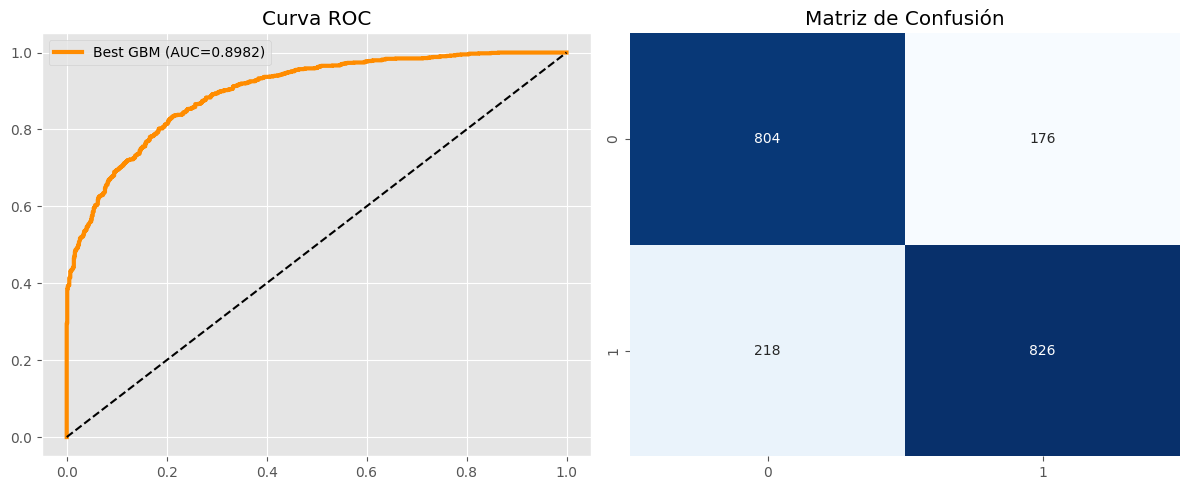

In [ ]:
y_pred = best_model.predict(X_val)
y_probs = best_model.predict_proba(X_val)[:, 1]

print(f"ACCURACY EN VALIDACIÓN (OPTIMIZADO): {accuracy_score(y_val, y_pred):.4f}")

# Reporte
print("\nReporte de Clasificación:")
print(classification_report(y_val, y_pred))

# Gráficos
plt.figure(figsize=(12, 5))

# ROC
auc = roc_auc_score(y_val, y_probs)
fpr, tpr, _ = roc_curve(y_val, y_probs)
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'Best GBM (AUC={auc:.4f})', color='darkorange', lw=3)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.legend()

# Matriz
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

## 5. Submission

In [ ]:
# Fit all models on full training data and create submissions
models = {
    'GradientBoosting': best_model_gb,
    'HistGradientBoosting': best_model_hist,
    'LightGBM': best_model_lgb,
    'XGBoost': best_model_xgb,
    'Ensemble_Voting': best_model_ensemble
}

print("Generando submisiones para todos los modelos...\n")

for model_name, model in models.items():
    # Fit on full training data
    model.fit(X, y)
    
    # Predictions on test set
    final_preds = model.predict(X_test_final)
    
    # Create submission DataFrame
    sub = pd.DataFrame({'Id': test_df['Id'], 'FreePass': final_preds})
    sub['FreePass'] = sub['FreePass'].astype(bool)
    
    # Save CSV
    filename = f'submission_{model_name}.csv'
    sub.to_csv(filename, index=False)
    print(f"✓ Archivo '{filename}' generado correctamente.")

print("\nTodas las submisiones han sido creadas exitosamente.")
print("\n📊 Recomendación: Comienza con 'submission_Ensemble_Voting.csv' (generalmente la mejor opción).")

Archivo 'submission_optimized_final.csv' generado correctamente.
